See `Dataset for Metric Alignment` on Notes 

## Set LLM to use

In [1]:
from langchain_openai.chat_models import ChatOpenAI
from ragas.llms import LangchainLLMWrapper

llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

## Metric - Factual correctness


In [2]:
from ragas.prompt import PydanticPrompt
from pydantic import BaseModel

class CreateQuestion(BaseModel):
    term: str
    answer_length: str
    answer_style: str

class QuestionAnswer(BaseModel):
    question: str
    answer: str

class QuestionAnswerPrompt(PydanticPrompt[CreateQuestion, QuestionAnswer]):
    instruction: str = (
        "Given a seed term, generate a question that expects an answer that fits the specified "
        "answer_length and answer_style."
    )
    input_model = CreateQuestion
    output_model = QuestionAnswer
    examples = [
        (
            CreateQuestion(
                term="thermodynamics",
                answer_length="long (50+ words)",
                answer_style="bullet points"
            ),
            QuestionAnswer(
                question="What are the fundamental laws of thermodynamics?",
                answer="""
- **First Law (Conservation of Energy)**: Energy cannot be created or destroyed; it can only be transformed from one form to another.
- **Second Law (Increase of Entropy)**: In any energy transfer, the total entropy (disorder) of an isolated system will increase over time.
- **Third Law (Absolute Zero Entropy)**: As the temperature of a perfect crystal approaches absolute zero, its entropy approaches zero.
- **Zeroth Law (Thermal Equilibrium)**: If two systems are in thermal equilibrium with a third system, they are in thermal equilibrium with each other.
"""
            )
        ),
    ]

In [3]:
from pydantic import BaseModel

class ModifyAnswer(BaseModel):
    original_answer: str
    action: str  # Expected actions: "rephrase", "similar_but_wrong", "change_response_format"

class ModifiedAnswer(BaseModel):
    new_answer: str

class ComparisonResponsePrompt(PydanticPrompt[ModifyAnswer, ModifiedAnswer]):
    instruction: str = (
        "Given an answer and a comparison type, generate a new response according to the given action. "
        "Ensure that the modified answer remains coherent."
    )
    input_model = ModifyAnswer
    output_model = ModifiedAnswer
    examples = [
        # Example for action: rephrase
        (
            ModifyAnswer(
                original_answer="The Eiffel Tower is located in Paris.",
                action="rephrase"
            ),
            ModifiedAnswer(
                new_answer="You can find the Eiffel Tower in Paris."
            )
        ),
        # Updated Example for action: similar_but_wrong
        (
            ModifyAnswer(
                original_answer="Plants convert sunlight into energy through photosynthesis.",
                action="similar_but_wrong"
            ),
            ModifiedAnswer(
                new_answer="Plants convert sunlight into energy through cellular respiration."
            )
        ),
        # Example for action: change_response_format
        (
            ModifyAnswer(
                original_answer="To bake a cake, you need flour, eggs, and sugar.",
                action="change_response_format"
            ),
            ModifiedAnswer(
                new_answer="Ingredients required:\n- Flour\n- Eggs\n- Sugar"
            )
        )
    ]

In [4]:
prompt = QuestionAnswerPrompt()
prompt_input = CreateQuestion(term="gravity", answer_length="long (50+ words)", answer_style="narrative")
output = await prompt.generate(data=prompt_input, llm=llm)

In [5]:
print(output.answer)

Gravity is a fundamental force that governs the motion of celestial bodies throughout the universe. It is the force of attraction between masses, and its effects can be observed on both small and large scales. On Earth, gravity gives weight to physical objects and causes them to fall towards the ground when dropped. In the vastness of space, gravity is responsible for the orbits of planets around stars, such as Earth's orbit around the Sun, and the orbits of moons around planets. It also plays a crucial role in the formation of galaxies, stars, and planetary systems. The gravitational pull of massive objects can bend light, a phenomenon known as gravitational lensing, which allows astronomers to study distant galaxies. Additionally, gravity influences the tides on Earth due to the gravitational interaction between the Earth and the Moon. Overall, gravity is a key force that shapes the structure and dynamics of the universe, affecting everything from the smallest particles to the larges

In [6]:
prompt = ComparisonResponsePrompt()
prompt_input = ModifyAnswer(original_answer=output.answer,N=2, action="change_response_format")
output = await prompt.generate(data=prompt_input, llm=llm)

In [7]:
print(output.new_answer)

Gravity is a fundamental force that governs the motion of celestial bodies throughout the universe. Key points include:

- Force of Attraction: Gravity is the force of attraction between masses, observable on both small and large scales.
- Effects on Earth: It gives weight to physical objects and causes them to fall towards the ground when dropped.
- Celestial Orbits: Responsible for the orbits of planets around stars, like Earth's orbit around the Sun, and moons around planets.
- Formation of Cosmic Structures: Plays a crucial role in the formation of galaxies, stars, and planetary systems.
- Gravitational Lensing: The gravitational pull of massive objects can bend light, allowing astronomers to study distant galaxies.
- Tidal Influence: Influences Earth's tides due to the gravitational interaction between the Earth and the Moon.

Overall, gravity shapes the structure and dynamics of the universe, affecting everything from the smallest particles to the largest cosmic structures.


In [8]:
# Define your percentages for each answer type
answer_length_dict = {
    "long (50+ words)": 0.75,    # 40%
    "short (1-5 words)": 0.05,     # 30%
    "medium (10-20 words)": 0.2   # 30%
}

answer_style_list = ["bullet point", "narrative"]
change_type_dict = {
    "rephrase": 0.25, # 50%
    "change_response_format":0.25,
    "similar_but_wrong":0.50
}


In [9]:
def load_terms():
    # Path to the file
    file_path = 'physics_terms.txt'
    
    # Reading the file into a list
    with open(file_path, 'r') as file:
        terms_list = [line.strip() for line in file.readlines()]

    return terms_list

In [10]:
len(load_terms())

130

In [11]:
import numpy as np
from tqdm import tqdm

In [12]:

samples = []
for term in tqdm(load_terms()[:100]):
    sample = {}    
    answer_type = np.random.choice(list(answer_length_dict.keys()),1,p=list(answer_length_dict.values()))[0]
    action_type = np.random.choice(list(change_type_dict.keys()),1,p=list(change_type_dict.values()))[0]
    answer_style = np.random.choice(answer_style_list,1)[0]
    prompt = QuestionAnswerPrompt()
    prompt_input = CreateQuestion(term=term, answer_length=answer_type,answer_style=answer_style)
    output = await prompt.generate(data=prompt_input, llm=llm)
    sample.update(
        {
            "user_input":output.question,
            "reference":output.answer,
            "term":term,
            "answer_type":answer_type
        }
    )

    prompt = ComparisonResponsePrompt()
    prompt_input = ModifyAnswer(original_answer=output.answer,N=2, action=action_type)
    output = await prompt.generate(data=prompt_input, llm=llm)
    sample.update({
        "response":output.new_answer,
        "action":action_type,
        "target": 1 if action_type in ["rephrase","change_response_format"] else 0,
    })
    

    samples.append(sample)
    
        

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:57<00:00,  6.58s/it]


In [13]:
from datasets import Dataset
dataset = Dataset.from_list(samples)

In [14]:
dataset.to_json("datasets/dataset_v2.json")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

158948

In [1]:
# dataset.push_to_hub("explodinggradients/physics_metrics_alignment")

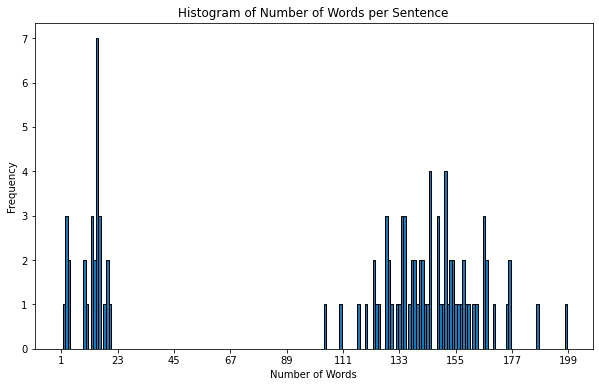

In [15]:
import matplotlib.pyplot as plt

def plot_word_histogram(input_list):
    # Count the number of words in each string
    word_counts = [len(sentence.split()) for sentence in input_list]
    
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(word_counts, bins=range(1, max(word_counts) + 2), edgecolor='black', align='left')
    
    plt.title('Histogram of Number of Words per Sentence')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    max_word_count = max(word_counts)
    bins = np.linspace(1, max_word_count + 1, num=10)  # Adjust the number of bins
    plt.xticks(bins)
    plt.show()

plot_word_histogram(dataset['reference'])

## Evaluation

In [1]:
import os
os.environ["LANGCHAIN_PROJECT"]= "Alignment"
os.environ["LANGCHAIN_TRACING_V2"] = "false"

In [2]:
from ragas.metrics import FactualCorrectness
from ragas import EvaluationDataset
from datasets import load_dataset, Dataset
dataset = Dataset.from_json("datasets/dataset_v2.json")

In [3]:
dataset[1]

{'user_input': 'What are the key concepts and principles of thermodynamics?',
 'reference': '\n- **Energy Conservation**: The total energy of an isolated system remains constant, though it can change forms.\n- **Entropy**: A measure of disorder or randomness in a system, which tends to increase over time in an isolated system.\n- **Thermal Equilibrium**: When two systems are in thermal contact and no heat flows between them, they are in thermal equilibrium.\n- **Heat Transfer**: The movement of thermal energy from one object or substance to another, driven by temperature differences.\n- **State Functions**: Properties that depend only on the state of the system, not on how it got there, such as internal energy, enthalpy, and entropy.\n',
 'term': 'thermodynamics',
 'answer_type': 'long (50+ words)',
 'response': '\n- **Energy Conservation**: The total energy of an isolated system can increase or decrease, depending on external influences.\n- **Entropy**: A measure of order or predictab

## 
Evaluating with different settings

In [4]:
from ragas import evaluate
import numpy as np

subsample = dataset
ragas_dataset = EvaluationDataset.from_hf_dataset(subsample)


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



def visualize(df_accuracies):

    plt.plot(df_accuracies['Threshold'], df_accuracies['Accuracy'], marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Threshold')
    plt.grid(True)
    plt.show()

def calculate_accuracy_over_thresholds(y_true, y_scores, thresholds=None):
    """
    Calculate accuracies over different thresholds starting from 0.5.

    Parameters:
    - y_true: array-like of shape (n_samples,), true binary targets (0 or 1)
    - y_scores: array-like of shape (n_samples,), predicted scores/probabilities (floats between 0 and 1)
    - thresholds: array-like of thresholds to evaluate. If None, defaults to np.arange(0.5, 1.01, 0.05)

    Returns:
    - df_results: pandas DataFrame with columns 'Threshold' and 'Accuracy'
    """
    if thresholds is None:
        thresholds = np.arange(0.5, 1.01, 0.1)
    
    results = []

    for thresh in thresholds:
        # Binarize the predicted scores based on the current threshold
        y_pred = (y_scores >= thresh).astype(int)
        
        # Calculate accuracy
        accuracy = (y_pred == y_true).mean()
        
        # Append the result to the list
        results.append({'Threshold': thresh, 'Accuracy': accuracy})
    
    # Convert the results list to a pandas DataFrame
    df_results = pd.DataFrame(results)
    visualize(df_results)
    return df_results

### Case 1: Ragas with default prompt + (No demo)

In [6]:
ragas_output = evaluate(ragas_dataset[:4], metrics=[FactualCorrectness(with_examples=False)],raise_exceptions=True)

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
ragas_output

{'factual_correctness': 0.2975}

In [9]:
pred = np.nan_to_num(ragas_output.to_pandas()['factual_correctness'].values).tolist()
real = subsample['target']

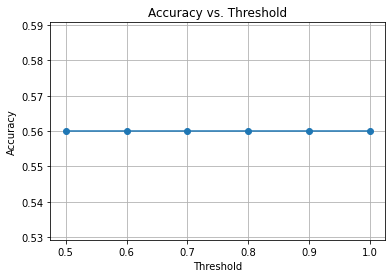

,Threshold,Accuracy
0,0.5,0.56
1,0.6,0.56
2,0.7,0.56
3,0.8,0.56
4,0.9,0.56
5,1.0,0.56


In [10]:
calculate_accuracy_over_thresholds(real,pred)


In [16]:
np.round(0.34,2)

0.34

In [17]:
0/1e-8

0.0

In [14]:
pred

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [11]:
ragas_output.to_pandas().to_csv("results/default_prompt_no_demo.csv",index=False)

In [ ]:
ragas_output.to_pandas()

## Case 2 : Ragas with default prompt + Random 3 demo

In [ ]:
scorer = FactualCorrectness(with_examples=True)

In [ ]:
ragas_output = evaluate(ragas_dataset, metrics=[scorer])

In [ ]:

pred = np.nan_to_num(ragas_output.to_pandas()['factual_correctness'].values).tolist()
real = subsample['target']

In [ ]:
calculate_accuracy_over_thresholds(real,pred)

In [ ]:
real

In [ ]:
pred

In [ ]:
ragas_output.to_pandas().to_csv("results/default_prompt_no_demo.csv",index=False)

In [ ]:
daa